In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.colors import ListedColormap
from matplotlib import cm

from math import tau  # tauday.com - Pi is wrong

plt.rcParams['font.size'] = 8

$$ P = \frac{\rho g^2}{64 \pi} T_e H_{m_0}^2 $$

In [2]:
RHO = 1000
G = 9.81

def wave_energy_flux(t, h):
    return RHO * G**2 * t * h**2 / (64 * np.pi)

In [3]:
NDIRS = 16
DIRS = np.linspace(0, 15*tau/16, 16)
RANGE = (-11.25, 371.25)
BARWIDTH = tau/16

def roseplot(d, x, bins=5, quantiles=True, opening=1.0, dirnames=False, xlabel=None, xleg=1.1, cmap=None, ax=None):
    if isinstance(bins, int):
        if quantiles:
            bin_edges = np.quantile(x, np.linspace(0, 1, bins + 1))
        else:
            bin_edges = np.histogram_bin_edges(x, bins)
        bin_edges[-1] = np.inf
    else:
        bin_edges = np.array(bins)
        bins = len(bin_edges) - 1
    n = len(d)
    hists = np.empty((bins, NDIRS))
    lbls = []
    for i in range(bins):
        x1 = bin_edges[i]
        x2 = bin_edges[i + 1]
        dbin = d[np.logical_and(x1 <= x, x < x2)]
        *hists[i], last = np.histogram(
            dbin, bins=NDIRS + 1, range=RANGE)[0] / n
        hists[i, 0] += last
        lbls.append(f'{x1:.1f}–{x2:.1f}')
    if ax is None:
        ax = plt.subplot(polar=True)
    ax.set_theta_direction(-1)
    ax.set_theta_zero_location("N")
    if dirnames:
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
    if isinstance(cmap, str) or cmap is None:
        cmap = plt.get_cmap(cmap)
    colors = cmap(np.linspace(0, 1, bins))
    bottoms = np.empty_like(hists)
    bottoms[0] = 0
    bottoms[1:] = np.cumsum(hists[:-1], 0)
    width = opening * BARWIDTH
    for hist, color, lbl, bottom in zip(hists, colors, lbls, bottoms):
        ax.bar(DIRS, hist, width=width, color=color, edgecolor="k", label=lbl, bottom=bottom)
    ax.legend(title=xlabel)
    ax.legend(title=xlabel, bbox_to_anchor=(xleg, 0, 0.5, 1), loc="center")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
    return ax

In [4]:
STR_MONTHS = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

def montly_mean_plot(df, col, lbl, width=0.8, color="gray", ax=None):
    mean = df[col].groupby(df.time.dt.month).agg({"mean"}).values.flatten()
    if ax is None:
        ax = plt.subplot()
    ax.bar(STR_MONTHS, mean, width=width, color=color)
    ax.tick_params(axis="x", labelrotation=60)
    ax.set_ylabel(lbl)
    return ax

In [5]:
def annual_energy(t, h, tedges, hedges, dt):
    bins = len(tedges) - 1
    e = np.zeros((bins, bins))
    for k in range(len(t)):
        i = np.where(tedges < t[k])[0][-1]
        j = np.where(hedges < h[k])[0][-1]
        e[i, j] += wave_energy_flux(t[k], h[k]) * dt
    return e / 40

In [6]:
def clabel_edge(cs, levels, ax, side='both', pad=0.005, **kwargs):
    '''Label contour lines at the edge of plot
    Args:
        levels (1d array): contour levels.
        cs (QuadContourSet obj): the return value of contour() function.
        ax (Axes obj): matplotlib axis.
    Keyword Args:
        side (str): on which side of the plot intersections of contour lines
            and plot boundary are checked. Could be: 'left', 'right', 'top',
            'bottom' or 'all'. E.g. 'left' means only intersections of contour
            lines and left plot boundary will be labeled. 'all' means all 4
            edges.
        pad (float): padding to add between plot edge and label text.
        **kwargs: additional keyword arguments to control texts. E.g. fontsize,
            color.
    '''
    from matplotlib.transforms import Bbox
    collections = cs.collections
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    bbox = Bbox.from_bounds(xlim[0], ylim[0], xlim[1]-xlim[0], ylim[1]-ylim[0])
    eps = 1e-5  # error for checking boundary intersection
    # -----------Loop through contour levels-----------
    for ii, lii in enumerate(levels):
        cii = collections[ii]  # contours for level lii
        pathsii = cii.get_paths()  # the Paths for these contours
        if len(pathsii) == 0:
            continue
        for pjj in pathsii:
            # check first whether the contour intersects the axis boundary
            if not pjj.intersects_bbox(bbox, False):  # False significant here
                continue
            xjj = pjj.vertices[:, 0]
            yjj = pjj.vertices[:, 1]
            # intersection with the left edge
            if side in ['left', 'all']:
                inter_idx = np.where(abs(xjj-xlim[0]) <= eps)[0]
                for kk in inter_idx:
                    inter_x = xjj[kk]
                    inter_y = yjj[kk]
                    ax.text(inter_x-pad, inter_y, lii,
                            ha='right',
                            va='center',
                            **kwargs)
            # intersection with the right edge
            if side in ['right', 'all']:
                inter_idx = np.where(abs(xjj-xlim[1]) <= eps)[0]
                for kk in inter_idx:
                    inter_x = xjj[kk]
                    inter_y = yjj[kk]
                    ax.text(inter_x+pad, inter_y, lii,
                            ha='left',
                            va='center',
                            **kwargs)
            # intersection with the bottom edge
            if side in ['bottom', 'all']:
                inter_idx = np.where(abs(yjj-ylim[0]) <= eps)[0]
                for kk in inter_idx:
                    inter_x = xjj[kk]
                    inter_y = yjj[kk]
                    ax.text(inter_x-pad, inter_y, lii,
                            ha='center',
                            va='top',
                            **kwargs)
            # intersection with the top edge
            if side in ['top', 'all']:
                inter_idx = np.where(abs(yjj-ylim[-1]) <= eps)[0]
                for kk in inter_idx:
                    inter_x = xjj[kk]
                    inter_y = yjj[kk]
                    ax.text(inter_x+pad, inter_y, lii,
                            ha='center',
                            va='bottom',
                            **kwargs)
    return

In [15]:
def histogram(t, h, tmax, hmax, bins, dt, nyears, levels, labelpad=25, cmap=None, ax=None):
    n, xedges, yedges = np.histogram2d(t, h, bins=bins, range=[[0, tmax], [0, hmax]])
    e = annual_energy(t, h, xedges, yedges, dt) / 1000
    hpy = n * dt / nyears
    xcenters = (xedges[:-1] + xedges[1:]) / 2
    ycenters = (yedges[:-1] + yedges[1:]) / 2
    x, y = np.meshgrid(np.linspace(0, tmax), np.linspace(0, hmax))
    z = wave_energy_flux(x, y) / 1000
    if isinstance(cmap, str) or cmap is None:
        cmap = plt.get_cmap(cmap)
    colors = cmap(np.linspace(0, 1, 64))
    colors[0][:3] = 1
    newcmap = ListedColormap(colors)
    if ax is None:
        ax = plt.subplot()
    _ax = ax.twinx()
    im = ax.imshow(e.T, origin="lower", extent=[0, tmax, 0, hmax], aspect=tmax/hmax, cmap=newcmap)
    cs = ax.contour(x, y, z, levels, extent=[0, tmax, 0, hmax], colors="gray", linewidths=0.75)
    clabel_edge(cs, levels, ax, side='right', pad=0.2)
    def ratio(i, j):
        erange = e.max() - e.min()
        return (e[i, j] - e.min()) / erange
    for i in range(bins):
        for j in range(bins):
            s = f"{hpy[i, j]:.0f}"
            if s != "0":
                ax.text(xcenters[i], ycenters[j], s, ha="center", va="center", color="w" if ratio(i, j) > 0.5 else "k", fontsize=6)
    ax.set_xticks(np.linspace(0, tmax, bins + 1))
    ax.set_yticks(np.linspace(0, hmax, bins + 1))
    ax.set_xlabel("Period (s)")
    ax.set_ylabel("Wave height (m)")
    cbar = ax.get_figure().colorbar(im, ax=ax, aspect=40)
    cbar.ax.set_ylabel("Annual energy (kWh/m)")
    ax.set_box_aspect(1)
    _ax.set_yticks([])
    _ax.set_ylabel("Power (kW/m)", labelpad=labelpad)
    return ax

In [8]:
def plot_wave_energy(df, tmax, hmax, bins, dt, nyears, levels, rose_bins, figsize, labelpad, xleg, cmap=None):
    fig = plt.figure(constrained_layout=True, figsize=figsize)
    gs = fig.add_gridspec(2, 2)

    if isinstance(cmap, str) or cmap is None:
        cmap = plt.get_cmap(cmap)

    ax1 = fig.add_subplot(gs[:, 0])
    ax1.set_title("a)", loc="center")
    histogram(df.perpw, df.swh, tmax, hmax, bins, dt, nyears, levels, labelpad=labelpad, cmap=cmap, ax=ax1)

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.set_title("b)", loc="center")
    montly_mean_plot(df, "wef_k", "Power (kW/m)", color=cmap(0.5), ax=ax2)

    ax3 = fig.add_subplot(gs[1, 1], polar=True)
    ax3.set_title("c)", loc="left")
    ax3.set_anchor('W')
    roseplot(df.dirpw, df.wef_k, bins=rose_bins, dirnames=True, xleg=xleg, cmap=cmap, xlabel="Power (kW/m)", ax=ax3)

    return fig

In [9]:
path_template = "C:/Users/casas/OneDrive/Uninorte/Projects/paper-energías/Filtrado/Boya {} Filtrado.csv"
buoys = ["Dibulla", "Manaure", "Riohacha", "Uribia"]
data = dict()

for buoy in buoys:
    path = path_template.format(buoy)
    df = pd.read_csv(path, parse_dates=["time"])
    df["wef"] = df.apply(lambda r: wave_energy_flux(r.perpw, r.swh), axis=1)
    df["wef_k"] = df.apply(lambda r: wave_energy_flux(r.perpw, r.swh) / 1000, axis=1)
    data[buoy] = df
    print(df.perpw.min(), df.perpw.max(), df.swh.min(), df.swh.max())

2.1344 22.8162 0.10448 1.86535
2.1344 20.7532 0.11456 1.93694
2.1344 20.7532 0.13741 2.00702
1.7658 20.7532 0.13198 2.08372


Dibulla
Manaure
Riohacha
Uribia


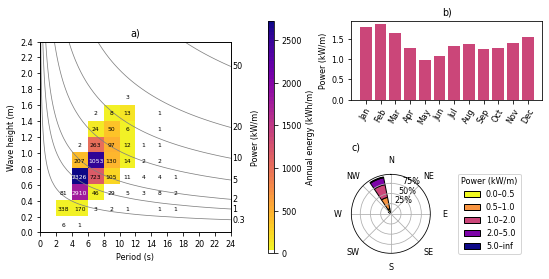

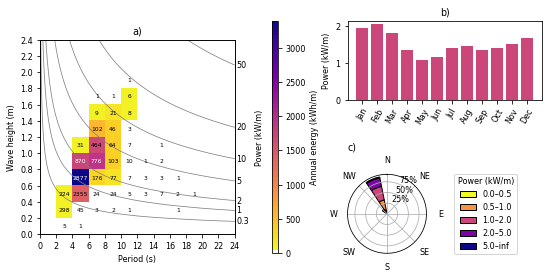

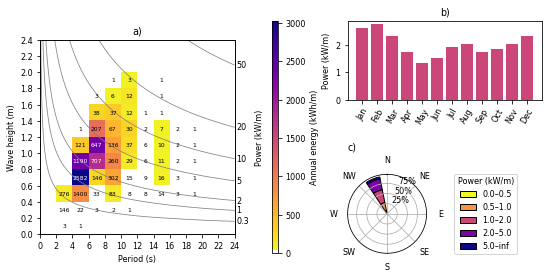

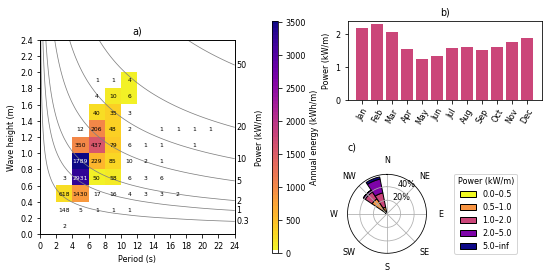

In [18]:
for buoy in buoys:
    fig = plot_wave_energy(data[buoy], 24, 2.4, 12, 3, 40,
                     [0.3, 1, 2, 5, 10, 20, 50],
                     [0, 0.5, 1, 2, 5, np.inf],
                     (7.5, 3.75),
                     20,
                     1.5,
                     cmap="plasma_r")
    fig.savefig("C:/Users/casas/OneDrive/Uninorte/Projects/paper-energías/Filtrado/" + buoy + ".png", dpi=300)
    print(buoy)